In [1]:
"""
https://medium.com/@khang.pham.exxact/text-classification-with-bert-7afaacc5e49b
"""

import os
import torch
from torch import nn
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertModel, AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report
import pandas as pd
from tqdm import tqdm

In [2]:
def load_imdb_data(data_file):
    df = pd.read_csv(data_file)
    texts = df['review'].tolist()
    labels = [1 if sentiment == "positive" else 0 for sentiment in df['sentiment'].tolist()]
    return texts, labels

In [3]:
data_file = "./archive/IMDB Dataset.csv"
texts, labels = load_imdb_data(data_file)

In [4]:
class TextClassificationDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_length):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_length = max_length
    def __len__(self):
        return len(self.texts)
    def __getitem__(self, idx):
        text = self.texts[idx]
        label = self.labels[idx]
        encoding = self.tokenizer(text, return_tensors='pt', max_length=self.max_length, padding='max_length', truncation=True)
        return {'input_ids': encoding['input_ids'].flatten(), 'attention_mask': encoding['attention_mask'].flatten(), 'label': torch.tensor(label)}

In [5]:
class BERTClassifier(nn.Module):
    def __init__(self, bert_model_name, num_classes):
        super(BERTClassifier, self).__init__()
        self.bert = BertModel.from_pretrained(bert_model_name)
        self.dropout = nn.Dropout(0.1)
        self.fc = nn.Linear(self.bert.config.hidden_size, num_classes)

    def forward(self, input_ids, attention_mask):
        outputs = self.bert(input_ids=input_ids, attention_mask=attention_mask)
        pooled_output = outputs.pooler_output
        x = self.dropout(pooled_output)
        logits = self.fc(x)
        return logits

In [6]:
from tqdm import tqdm

def train(model, teach_model, data_loader, optimizer, scheduler, device):
    model.train()
    teach_model.eval()
    total_loss = 0
    for batch in tqdm(data_loader):
        optimizer.zero_grad()
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        
        stud_output = model(input_ids=input_ids, attention_mask=attention_mask)
        with torch.no_grad():
            teach_output = teach_model(input_ids=input_ids, attention_mask=attention_mask)
        
        # print('111111111')
        # print(labels)
        # print(stud_output[:5])
        # print(teach_output[:5])

        # criterion  = nn.CrossEntropyLoss()
        # loss = criterion(stud_output, teach_output)

        criterion = torch.nn.KLDivLoss(reduction='batchmean')
        # print((stud_output+0.01).log())
        # print(teach_output)
        loss = criterion((stud_output+0.01).log(), teach_output)

        # print('2222222222')
        # print(loss)
        total_loss += loss
        loss.backward()
        optimizer.step()
        scheduler.step()
        
    return total_loss

In [7]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [8]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)
    return "positive" if preds.item() == 1 else "negative"

In [15]:
# Set up parameters
bert_teach_model_name = 'bert-large-uncased'
bert_stud_model_name = 'bert-base-uncased'
num_classes = 2
max_length = 128
batch_size = 16
num_epochs = 5
learning_rate = 2e-5
# learning_rate = 0.005

In [10]:
train_texts, val_texts, train_labels, val_labels = train_test_split(texts, labels, test_size=0.2, random_state=42)

In [11]:
stud_tokenizer = BertTokenizer.from_pretrained(bert_stud_model_name)
stud_train_dataset = TextClassificationDataset(train_texts, train_labels, stud_tokenizer, max_length)
stud_val_dataset = TextClassificationDataset(val_texts, val_labels, stud_tokenizer, max_length)
stud_train_dataloader = DataLoader(stud_train_dataset, batch_size=batch_size, shuffle=True)
stud_val_dataloader = DataLoader(stud_val_dataset, batch_size=batch_size)

teach_tokenizer = BertTokenizer.from_pretrained(bert_teach_model_name)
teach_train_dataset = TextClassificationDataset(train_texts, train_labels, teach_tokenizer, max_length)
teach_val_dataset = TextClassificationDataset(val_texts, val_labels, teach_tokenizer, max_length)
teach_train_dataloader = DataLoader(teach_train_dataset, batch_size=batch_size, shuffle=True)
teach_val_dataloader = DataLoader(teach_val_dataset, batch_size=batch_size)

In [12]:
def evaluate(model, data_loader, device):
    model.eval()
    predictions = []
    actual_labels = []
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            
            outputs = outputs.exp()

            _, preds = torch.max(outputs, dim=1)
            predictions.extend(preds.cpu().tolist())
            actual_labels.extend(labels.cpu().tolist())
    return accuracy_score(actual_labels, predictions), classification_report(actual_labels, predictions)

In [13]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# teach_model = BERTClassifier(bert_teach_model_name, num_classes)
# # teach_model = torch.load("bert_classifier_large_total2.pth")
# teach_model = torch.load("bert_classifier_large_total3.pth")
# teach_model.eval()

# accuracy, report = evaluate(teach_model, stud_val_dataloader, device)
# print(accuracy)
# print(report)

In [14]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # stud_model = BERTClassifier(bert_stud_model_name, num_classes)
# stud_model = torch.load("stud/bert_classifier_student_total3.pth")
# stud_model.eval()
# stud_train_dataloader
# evaluate(stud_model, stud_train_dataloader, device)

In [15]:
# device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
# # stud_model = BERTClassifier(bert_stud_model_name, num_classes)
# stud_model = torch.load("bert_classifier_student_total3.pth")
# stud_model.eval()

# with torch.no_grad():
#     evaluate(stud_model, stud_train_dataloader, device)

In [13]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
teach_model = BERTClassifier(bert_teach_model_name, num_classes)
teach_model = torch.load("bert_classifier_large_total4.pth")
teach_model.to(device)

stud_model = BERTClassifier(bert_stud_model_name, num_classes)  
stud_model.to(device)

BERTClassifier(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=Tru

In [14]:
optimizer = AdamW(stud_model.parameters(), lr=learning_rate)
total_steps = len(stud_train_dataloader) * num_epochs
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)

/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/transformers/optimization.py:411: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [18]:
import pickle

i = 0
losses, accuracys = [], []
for epoch in range(num_epochs):
    i += 1
    print(f"Epoch {epoch + 1}/{num_epochs}")
    loss = train(stud_model, teach_model, stud_train_dataloader, optimizer, scheduler, device)
    accuracy, report = evaluate(stud_model, stud_val_dataloader, device)
    losses.append(loss)
    accuracys.append(accuracy)
    print(f"Validation Accuracy: {accuracy:.4f}")
    print(report)
    # torch.save(model.state_dict(), "bert_classifier_large_"+str(i)+".pth")
    torch.save(stud_model, "bert_classifier_student_total"+str(i)+".pth")
    
    with open('losses.pkl', 'wb') as f:
        pickle.dump(losses, f)

    with open('accuracys.pkl', 'wb') as f:
        pickle.dump(accuracys, f)

Epoch 1/10


100%|██████████| 2500/2500 [17:34<00:00,  2.37it/s]


Validation Accuracy: 0.8677
              precision    recall  f1-score   support

           0       0.82      0.93      0.88      4961
           1       0.92      0.80      0.86      5039

    accuracy                           0.87     10000
   macro avg       0.87      0.87      0.87     10000
weighted avg       0.87      0.87      0.87     10000

Epoch 2/10


100%|██████████| 2500/2500 [17:33<00:00,  2.37it/s]


Validation Accuracy: 0.8779
              precision    recall  f1-score   support

           0       0.86      0.90      0.88      4961
           1       0.90      0.86      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Epoch 3/10


100%|██████████| 2500/2500 [17:23<00:00,  2.40it/s]


Validation Accuracy: 0.8823
              precision    recall  f1-score   support

           0       0.88      0.89      0.88      4961
           1       0.89      0.88      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Epoch 4/10


100%|██████████| 2500/2500 [17:16<00:00,  2.41it/s]


Validation Accuracy: 0.8809
              precision    recall  f1-score   support

           0       0.87      0.89      0.88      4961
           1       0.89      0.87      0.88      5039

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000

Epoch 5/10


100%|██████████| 2500/2500 [17:18<00:00,  2.41it/s]


Validation Accuracy: 0.8875
              precision    recall  f1-score   support

           0       0.90      0.87      0.88      4961
           1       0.87      0.91      0.89      5039

    accuracy                           0.89     10000
   macro avg       0.89      0.89      0.89     10000
weighted avg       0.89      0.89      0.89     10000

Epoch 6/10


100%|██████████| 2500/2500 [17:15<00:00,  2.41it/s]
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

Validation Accuracy: 0.4961
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4961
           1       0.00      0.00      0.00      5039

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000

Epoch 7/10


100%|██████████| 2500/2500 [17:18<00:00,  2.41it/s]
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

Validation Accuracy: 0.4961
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4961
           1       0.00      0.00      0.00      5039

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000

Epoch 8/10


100%|██████████| 2500/2500 [17:16<00:00,  2.41it/s]
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

Validation Accuracy: 0.4961
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4961
           1       0.00      0.00      0.00      5039

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000

Epoch 9/10


100%|██████████| 2500/2500 [17:16<00:00,  2.41it/s]
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

Validation Accuracy: 0.4961
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4961
           1       0.00      0.00      0.00      5039

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000

Epoch 10/10


100%|██████████| 2500/2500 [17:16<00:00,  2.41it/s]
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/home/vil/anaconda3/envs/MJ/lib/python3.9/site-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average

Validation Accuracy: 0.4961
              precision    recall  f1-score   support

           0       0.50      1.00      0.66      4961
           1       0.00      0.00      0.00      5039

    accuracy                           0.50     10000
   macro avg       0.25      0.50      0.33     10000
weighted avg       0.25      0.50      0.33     10000



In [25]:
import pickle

with open('losses.pkl', 'rb') as f:
    losses = pickle.load(f)
    
with open('accuracys.pkl', 'rb') as f:
    accuracys = pickle.load(f)

losses = [i.item() for i in losses]

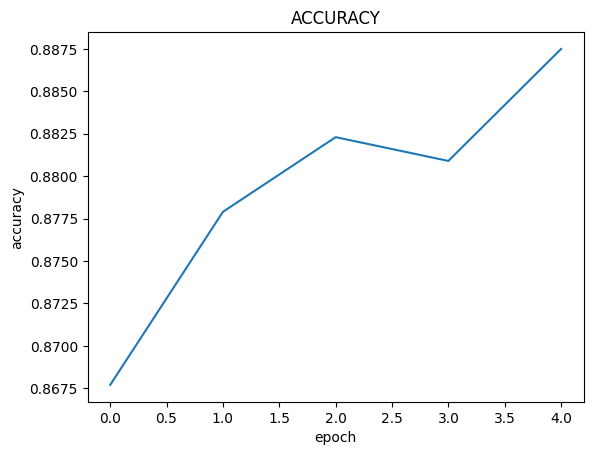

In [26]:
import matplotlib.pyplot as plt

plt.plot(accuracys[:5])
plt.xlabel('epoch')
plt.ylabel('accuracy')
plt.title('ACCURACY')
plt.show()

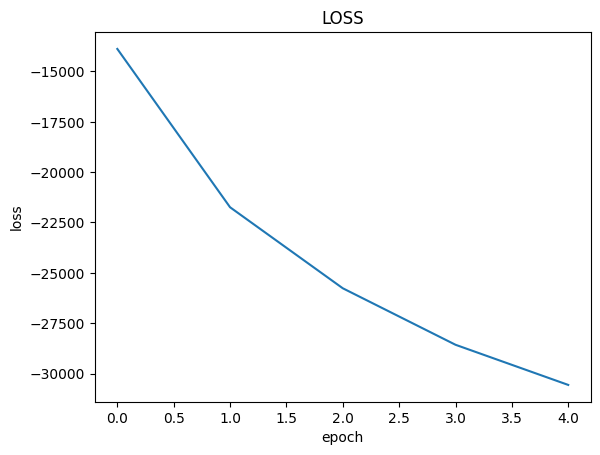

In [27]:
plt.plot(losses[:5])
plt.xlabel('epoch')
plt.ylabel('loss')
plt.title('LOSS')
plt.show()

In [48]:
def predict_sentiment(text, model, tokenizer, device, max_length=128):
    model.eval()
    encoding = tokenizer(text, return_tensors='pt', max_length=max_length, padding='max_length', truncation=True)
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)

    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs, dim=1)

    return "positive" if preds.item() == 1 else "negative"

In [49]:
stud_model = torch.load("bert_classifier_student_total4.pth").to(device)

In [50]:
# Test sentiment prediction
test_text = "The movie was great and I really enjoyed the performances of the actors."
sentiment = predict_sentiment(test_text, teach_model, teach_tokenizer, device)
print("The movie was great and I really enjoyed the performances of the actors.")
print(f"Predicted sentiment: {sentiment}")

The movie was great and I really enjoyed the performances of the actors.
Predicted sentiment: positive


In [51]:
# Test sentiment prediction
test_text = "The movie was great and I really enjoyed the performances of the actors."
sentiment = predict_sentiment(test_text, stud_model, stud_tokenizer, device)
print("The movie was great and I really enjoyed the performances of the actors.")
print(f"Predicted sentiment: {sentiment}")

The movie was great and I really enjoyed the performances of the actors.
Predicted sentiment: positive
